In [1]:
%load_ext autoreload
%autoreload 2

## Modelo Baseline: TFIDF + Ridge

In [2]:
from time import time
from datetime import timedelta

import numpy as np
import pandas as pd
import pylab
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import loguniform, shapiro
from statsmodels.stats.diagnostic import lilliefors

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot, PredictionError, CooksDistance

In [3]:
# alldf = pd.read_csv("../data/prep/clean_ruddit.csv")
train = pd.read_csv("../data/prep/train_ruddit.csv")
test = pd.read_csv("../data/prep/test_ruddit.csv")
print(train.shape[0], test.shape[0])

4566 1142


In [4]:
X_train, y_train = list(train["clean_text"].str.split().values), list(train["score"].values)
X_test, y_test = list(test["clean_text"].str.split().values), list(test["score"].values)

In [5]:
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=lambda doc: doc,
    preprocessor=lambda doc: doc,
    token_pattern=None
)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [6]:
len(tfidf.vocabulary_) # vocabulary length

10208

In [7]:
X_train.shape

(4566, 10208)

In [8]:
for k, v in zip(tfidf.vocabulary_.keys(), tfidf.vocabulary_.values()):
    print(k) if v == 0 else 0

!


In [9]:
tmp = tfidf.transform([["!"], ["hello", "!", "fuck"], ["people", "!", "!"]]).todense()
tmp

matrix([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.38027714, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.92412427, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [10]:
param_grid = {
    # "solver": ["auto", "cholesky", "lsqr", "saga"],
    "alpha": np.logspace(-5, 5, 11)
}
baseline_model = Ridge(fit_intercept=True, random_state=2)
# baseline_model.fit(X_train, y_train)

In [11]:
t0 = time()
baseline_search = GridSearchCV(estimator=baseline_model, param_grid=param_grid,
                                       scoring="neg_mean_squared_error", cv=5, n_jobs=-1, verbose=4)
baseline_search.fit(X_train, y_train)
# print(baseline_random_search)
print("\nBaseline training time: {}".format(timedelta(seconds=time() - t0)))

Fitting 5 folds for each of 11 candidates, totalling 55 fits

Baseline training time: 0:00:02.636145


In [12]:
print("Scorer: {}".format(baseline_search.scorer_))
print("Mejor configuración:")
print(baseline_search.best_estimator_)
print("MSE del mejor modelo tras la validación cruzada: {}".format(
    round(baseline_search.best_score_, 4)))

Scorer: make_scorer(mean_squared_error, greater_is_better=False)
Mejor configuración:
Ridge(random_state=2)
MSE del mejor modelo tras la validación cruzada: -0.053


In [13]:
cv_results = baseline_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)[["params", "mean_test_score", "std_test_score"]]
cv_results_df[["mean_test_score", "std_test_score"]] = cv_results_df[
    ["mean_test_score", "std_test_score"]].apply(lambda x: round(x, 4))
cv_results_df["alpha"] = cv_results_df["params"].apply(lambda params_dict: params_dict["alpha"])
# cv_results_df["solver"] = cv_results_df["params"].apply(lambda params_dict: params_dict["solver"])
cv_results_df.drop(columns="params", inplace=True)
cv_results_df["mean_test_score"] =  - cv_results_df["mean_test_score"] * 100
cv_results_df["std_test_score"] =  cv_results_df["std_test_score"] * 100

In [14]:
# Ranking de candidatos
cv_results_df.sort_values(by="mean_test_score", ascending=True).reset_index(drop=True).rename(
    columns={"mean_test_score": "mean_mse", "std_test_score": "std_mse"})

,mean_mse,std_mse,alpha
0,5.30,0.29,1.00000
1,6.24,0.29,0.10000
2,7.13,0.39,10.00000
3,9.30,0.29,0.01000
4,10.05,0.65,100.00000
5,10.82,0.73,1000.00000
6,10.91,0.74,10000.00000
7,10.91,0.74,100000.00000
8,13.67,1.05,0.00100
9,16.94,2.36,0.00010


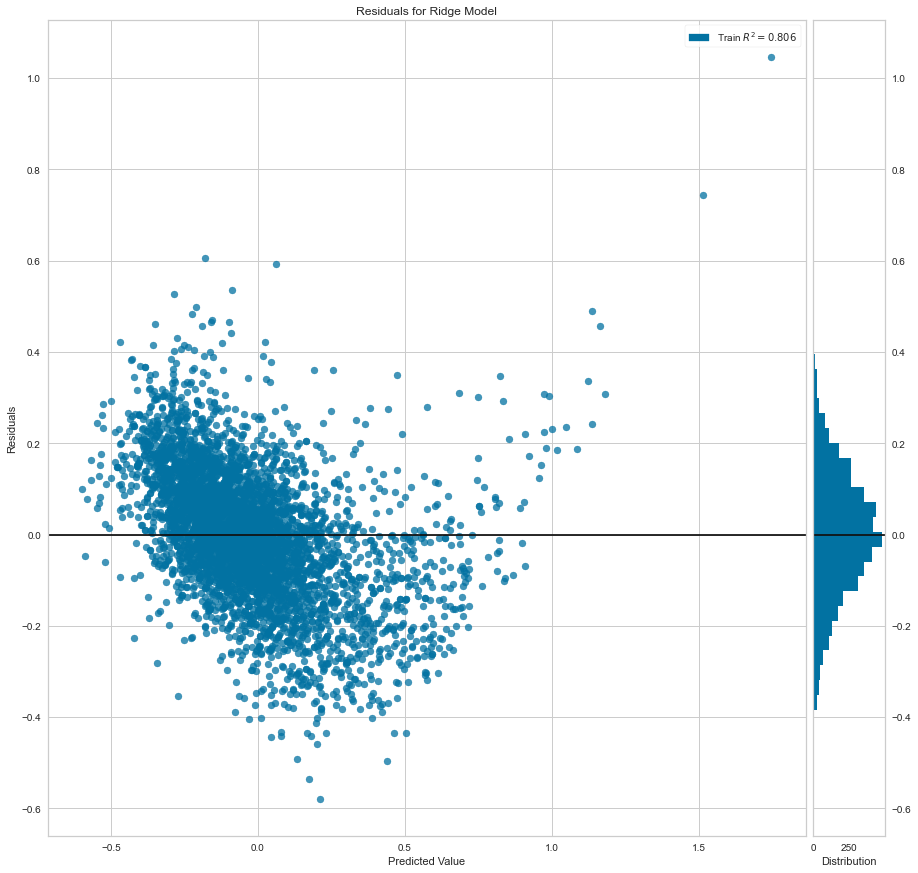

MSE: 5.2%


In [15]:
# Hold-out validation and residuals analysis
fig, ax = plt.subplots(figsize=(15, 15))
selected_model = Ridge(alpha=1, random_state=2)
visualizer = ResidualsPlot(selected_model, hist=True)
visualizer.fit(X_train, y_train)
visualizer.show();

y_pred = selected_model.predict(X_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
print("MSE:", str(round(mse * 100, 2)) + "%")

### Observaciones
En la grafica de residuos vs predicciones podemos comprobar si los supuestos de linealidad se cumplen y si la regresión ha sido bien ajustada. En este caso podemos observar que los residuos siguen una **distribución normal de media cero**. Además vemos que los residuos están aleatoriamente distribuidos alrededor del cero (a excepcion de un par de outliers a la derecha) por lo que **se cumple homocedasticidad** en el ajuste. Tras el análisis concluimos que el modelo está bien ajustado y los datos no necesitan de ninguna transformación previa.

Para corroborar la normalidad de los residuos, mostramos a continuación la gráfica Q-Q:

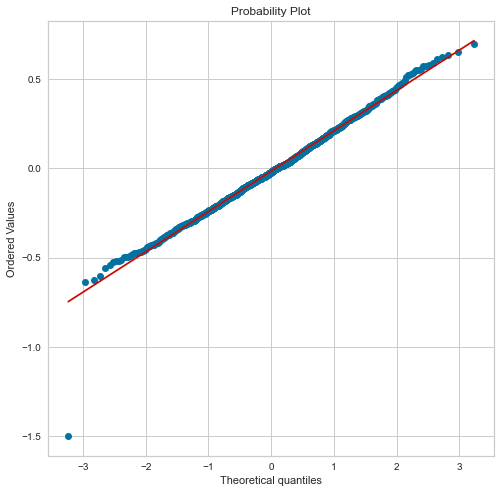

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
y_test = np.array(y_test)
residuals = (y_test - y_pred)
# Elimino outliers (solo uno)
residuals = list(filter(lambda s: s < .7, residuals))
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

In [17]:
stat, pvalue = lilliefors(residuals)
print("Lilliefors p-value:", round(pvalue, 6))

Lilliefors p-value: 0.05451


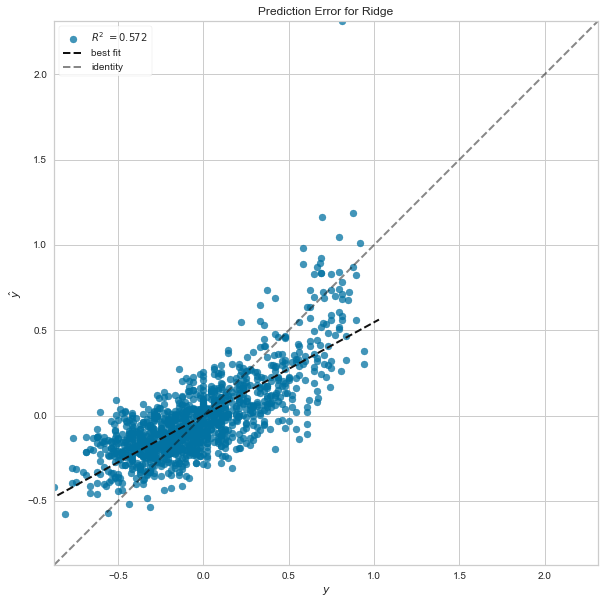

In [18]:
# Prediction Error Plot
fig, ax = plt.subplots(figsize=(10, 10))
selected_model = Ridge(alpha=1, random_state=2)
visualizer = PredictionError(selected_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

In [19]:
# Adjusted R-square
ar2 = 1 - (1 - selected_model.score(X_train, y_train)) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
round(ar2, 2)

1.16